scikit-learn, Machine Learning in Python
- Simple and efficient tools for predictive data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license


Check also: https://scikit-learn.org/stable/index.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

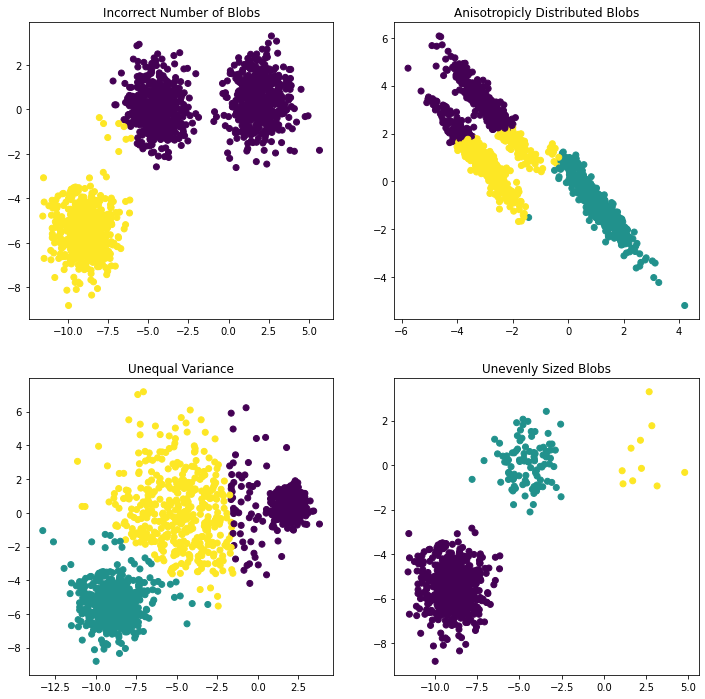

In [2]:
plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()